# **K-Compress: Image Compression using K-Means**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import time
import imageio
from sklearn.cluster import KMeans

### Select 16 Colors

In [2]:
input_folder = "input_image/"
input_filename = input_folder + os.listdir(input_folder)[0]

In [3]:
img = cv2.imread(input_filename, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
img = img/255

In [5]:
print("Shape of input image: ", img.shape)
orig_shape = img.shape

Shape of input image:  (1280, 1920, 3)


In [6]:
# Image is reshaped into an m x 3 matrix, where m is the total pixels in the image
# Each row represents 1 pixel

X = np.reshape(img, (img.shape[0] * img.shape[1], 3))

In [7]:
X.shape

(2457600, 3)

In [8]:
K = 16
tic = time.time()

kmeans = KMeans(n_clusters=K, random_state=0,verbose=1, init='k-means++', n_init=1).fit(X)

toc = time.time()
print('\nTraining Complete in {} seconds'.format(np.round(toc-tic)))

Initialization complete
Iteration 0, inertia 4119.3132948838975.
Iteration 1, inertia 3441.5460103309997.
Iteration 2, inertia 3227.6176415922405.
Iteration 3, inertia 3118.5012754195113.
Iteration 4, inertia 3071.044319370724.
Iteration 5, inertia 3044.827581583334.
Iteration 6, inertia 3029.005598287355.
Iteration 7, inertia 3017.3290346931794.
Iteration 8, inertia 3008.7305474695704.
Iteration 9, inertia 3000.1315481825604.
Iteration 10, inertia 2993.25768618479.
Iteration 11, inertia 2987.7824640803983.
Iteration 12, inertia 2982.6948754014516.
Iteration 13, inertia 2977.811106497429.
Iteration 14, inertia 2973.553229228104.
Iteration 15, inertia 2970.7390839555637.
Iteration 16, inertia 2967.8544436046604.
Iteration 17, inertia 2965.0953360130293.
Iteration 18, inertia 2962.2166602880743.
Iteration 19, inertia 2960.7655047701896.
Iteration 20, inertia 2959.1670991479127.
Iteration 21, inertia 2957.8737206354317.
Iteration 22, inertia 2956.804770554181.
Iteration 23, inertia 2955.6

### Compress Image:

In [9]:
output_folder = "compressed_image/"

In [10]:
C = kmeans.predict(X)
centroids = kmeans.cluster_centers_

In [11]:
C = C.astype(np.int8).squeeze()

In [12]:
def merge_to_byte(C):
    """as the smallest data type in python is of size 1 byte
    The merge_to_byte function takes two 4-bit numbers (actually 1 bytes) as input 
    and combines them into a single byte"""
    
    packed_bytes = []
    
    for i in range(0, C.shape[0], 2):

        n2 = C[i+1] << 4
        packed_byte = n2 | C[i]
        
        packed_bytes.append(packed_byte)
        
    return np.array(packed_bytes, dtype=np.uint8)

In [13]:
def save_as_RGB(packed_bytes):
    
    m = packed_bytes.shape[0]
    
    dim = np.ceil(np.sqrt(m/3))
    dim = int(dim)
    tot = dim * dim * 3
    pad = int(tot - m)
    
    padding = np.array([1] * pad, dtype=np.uint8)

    padded_packed_bytes = np.append(packed_bytes, padding)
    
    tmp = np.reshape(padded_packed_bytes, (dim, dim, 3))
    
    imageio.imwrite(output_folder+"color_mapping_image_RGB.png", tmp)
    
    return pad

In [14]:
def save_as_grey(packed_bytes, orig_shape):
    
    l, b, _ = orig_shape
    
    if l > b:
        l = int(l/2)
    else:
        b = int(b/2)
    
    tmp = np.reshape(packed_bytes, (l,b))
    
    imageio.imwrite(output_folder+"color_mapping_image_grey.png", tmp)

In [15]:
packed_bytes = merge_to_byte(C)

In [16]:
save_as_grey(packed_bytes, orig_shape)

In [17]:
np.save(output_folder+"16_colors", centroids)

### Compression Evaluation:

In [18]:
def get_foldercontent_size(folder_path):
    
    tsize = 0
    
    for file in os.listdir(folder_path):
        tsize += os.path.getsize(folder_path + file)

    return np.round(tsize/1024, 2)

In [19]:
input_size = get_foldercontent_size(input_folder)

In [20]:
output_size = get_foldercontent_size(output_folder)

In [21]:
ratio = ((input_size - output_size) / input_size) * 100
compression_ratio = np.round(ratio, 2)

In [22]:
cratio = (output_size/input_size)*100
cratio = np.round(cratio, 2)

In [23]:
result_string = """
Compression Evaluation Results:
--------------------------------

Input Image:
- Filename: {0}
- Size: {1} KB

Output Image (Compressed):
- Filename: {2}
- Size: {3} KB

Compression Details:
- Original Image Size: {1} KB
- Compressed Image Size: {3} KB
- Compression Ratio ≈ {4}%

This represents a compression ratio of approximately {4}%, 
indicating that the compressed image is roughly {5}% of the size of the original image.
""".format(input_filename, input_size, os.listdir(output_folder), output_size, compression_ratio, cratio)

print(result_string)


Compression Evaluation Results:
--------------------------------

Input Image:
- Filename: input_image/img.png
- Size: 3987.85 KB

Output Image (Compressed):
- Filename: ['16_colors.npy', 'color_mapping_image_grey.png']
- Size: 637.64 KB

Compression Details:
- Original Image Size: 3987.85 KB
- Compressed Image Size: 637.64 KB
- Compression Ratio ≈ 84.01%

This represents a compression ratio of approximately 84.01%, 
indicating that the compressed image is roughly 15.99% of the size of the original image.



### Comparsion: Original & Compressed Image

In [24]:
cm = cv2.imread(output_folder+"color_mapping_image_grey.png", cv2.IMREAD_GRAYSCALE)

In [25]:
cm = np.reshape(cm, (cm.shape[0] * cm.shape[1], 1)).squeeze()

In [26]:
def split_byte(cm):
    
    m = len(cm)
    unpacked_bytes = []
    
    for i in range(m):
        
        n2 = cm[i] >> 4
        n1 = cm[i] & 0b00001111
        
        unpacked_bytes.append(n1)
        unpacked_bytes.append(n2)
        
    return unpacked_bytes
    

In [27]:
unpacked_bytes = split_byte(cm)
C = np.array(unpacked_bytes)

In [28]:
# Image is recovered from the indices by mapping each pixel to the corresponding cluster centroid

X_recovered = centroids[C.astype(int).tolist(),:]

In [29]:
# Reshape the recovered image into proper dimensions

# X_recovered = np.reshape(X_recovered, (img.shape[0], img.shape[1], 3))
X_recovered = np.reshape(X_recovered, orig_shape)

Text(0.5, 1.0, 'Compressed Image')

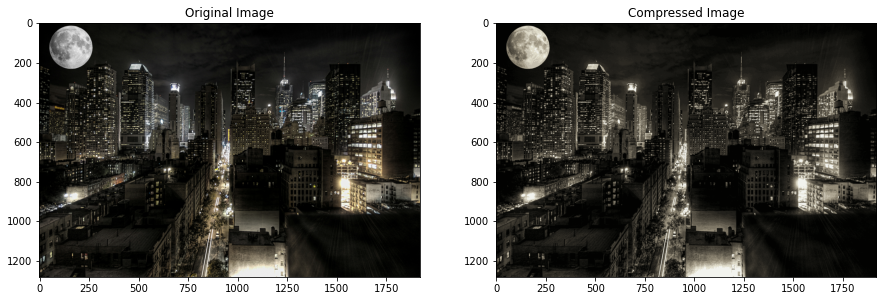

In [30]:
fig, axs = plt.subplots(1,2, squeeze=False, figsize=(15, 15))
axs[0,0].imshow(img)
axs[0,0].set_title("Original Image")
axs[0,1].imshow(X_recovered)
axs[0,1].set_title("Compressed Image")